In [8]:
%pylab inline
from __future__ import print_function

import cPickle as pickle
import enum
import os
import time
import IPython

import numpy as np
import scipy
import sklearn.metrics.pairwise

import librosa

Populating the interactive namespace from numpy and matplotlib


In [32]:
def read_list_file(filename):
    """Read a text file with one item per line."""
    items = []
    with open(filename, 'r') as f:
        for line in f:
            items.append(line.strip())
    return items

def read_beat_chroma_labels(filename):
    """Read back a precomputed beat-synchronous chroma record."""
    with open(filename, "r") as f:
        beat_times, chroma_features, label_indices = pickle.load(f)
    return beat_times, chroma_features, label_indices

def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)

In [480]:
def chroma_rotate(chroma_features, semitones):
    """Shift the chroma bins up by semitones (down if negative)."""
    num_chroma = chroma_features.shape[-1]
    semitones = (semitones + num_chroma) % num_chroma
    column_permutation = np.hstack([np.arange(num_chroma - semitones, num_chroma), 
                                    np.arange(num_chroma - semitones)])
    print(column_permutation)
    return chroma_features[:, column_permutation]

#plt.figure(figsize=(12, 3))
#my_imshow(chroma_rotate(ftrs_B, -1)[:100].transpose())
#colorbar()

In [41]:
os.chdir('/Users/dpwe/Downloads/e4896/elene4896/prac11')

In [536]:
DATA_DIR = '/Users/dpwe/Downloads/coversongs'
MP3_DIR = os.path.join(DATA_DIR, 'covers32k')
PKL_DIR = os.path.join(DATA_DIR, 'beatchromftrs')
url_base = 'http://labrosa.ee.columbia.edu:8013/'

In [33]:
ids_A = read_list_file(os.path.join(DATA_DIR, 'list1.txt'))
ids_B = read_list_file(os.path.join(DATA_DIR, 'list2.txt'))

In [539]:
ix = 0
id_A = ids_A[ix]
print(id_A)
IPython.display.Audio(url=url_base + id_A + '.mp3')

A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale


In [540]:
id_B = ids_B[ix]
print(id_B)
IPython.display.Audio(url=url_base + id_B + '.mp3')

A_Whiter_Shade_Of_Pale/procol_harum+Greatest_Hits+2-A_Whiter_Shade_Of_Pale


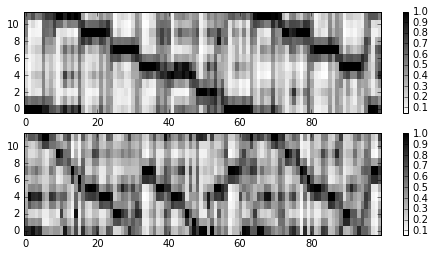

In [541]:
times_A, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_A + '.pkl'))
times_B, ftrs_B, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_B + '.pkl'))
plt.figure(figsize=(8,4))
subplot(211)
my_imshow(ftrs_A[:100].transpose())
colorbar()
subplot(212)
my_imshow(ftrs_B[:100].transpose())
colorbar()

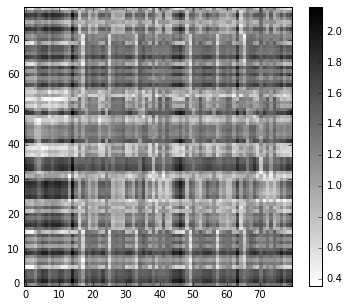

In [530]:
local_costs = sklearn.metrics.pairwise.pairwise_distances(ftrs_A, ftrs_B)
plt.figure(figsize=(6,5))
my_imshow(local_costs[:80, :80])
colorbar()

In [531]:
import numba

DIAGONAL = 0
HORIZONTAL = 1
VERTICAL = 2

def find_traceback(traceback_matrix, ending_row, ending_col, local_costs_matrix=None):
    row = ending_row
    col = ending_col
    path = [(row, col)]
    path_costs = []
    if local_costs_matrix is not None:
        path_costs.append(local_costs_matrix[row, col])
    while row > 0 or col > 0:
        predecessor = traceback_matrix[row, col]
        if predecessor == HORIZONTAL:
            col = col - 1
        elif predecessor == VERTICAL:
            row = row - 1
        else:
            col = col - 1
            row = row - 1
        path.append((row, col))
        if local_costs_matrix is not None:
            path_costs.append(local_costs_matrix[row, col])
    return np.array(path[::-1]), np.array(path_costs[::-1])

@numba.jit(nopython=True)
def dtw_core(dist_mat, add_pen, traceback):
    """Core dynamic programming routine for DTW.
    `dist_mat` and `traceback` will be modified in-place.
    Parameters
    ----------
    dist_mat : np.ndarray
        Distance matrix to update with lowest-cost path to each entry.
    add_pen : int or float
        Additive penalty for non-diagonal moves.
    traceback : np.ndarray
        Matrix to populate with the lowest-cost traceback from each entry.
    """
    # At each loop iteration, we are computing lowest cost to D[i, j]
    for row in xrange(1, dist_mat.shape[0]):
        dist_mat[row, 0] += dist_mat[row - 1, 0] + add_pen
        traceback[row, 0] = VERTICAL
    for col in xrange(1, dist_mat.shape[1]):
        dist_mat[0, col] += dist_mat[0, col - 1] + add_pen
        traceback[0, col] = HORIZONTAL
    for col in xrange(1, dist_mat.shape[1]):
        for row in xrange(1, dist_mat.shape[0]):
            diag_cost = dist_mat[row - 1, col - 1]
            vert_cost = dist_mat[row - 1, col] + add_pen
            horiz_cost = dist_mat[row, col - 1] + add_pen
            # Diagonal move (which has no penalty) is lowest
            if diag_cost <= horiz_cost and diag_cost <= vert_cost:
                traceback[row, col] = DIAGONAL
                dist_mat[row, col] += diag_cost
            # Horizontal move (has penalty)
            elif horiz_cost <= vert_cost:
                traceback[row, col] = HORIZONTAL
                dist_mat[row, col] += horiz_cost
            # Vertical move (has penalty)
            else:
                traceback[row, col] = VERTICAL
                dist_mat[row, col] += vert_cost

def dtw(local_costs, penalty=0.2):
    distance_matrix = np.copy(local_costs)
    traceback = np.empty(distance_matrix.shape, np.uint8)
    dtw_core(distance_matrix, penalty, traceback)
    path, path_costs = find_traceback(traceback, distance_matrix.shape[0] - 1, distance_matrix.shape[1] - 1, 
                                      local_costs + penalty*(traceback != DIAGONAL))
    return path, distance_matrix[-1, -1], path_costs

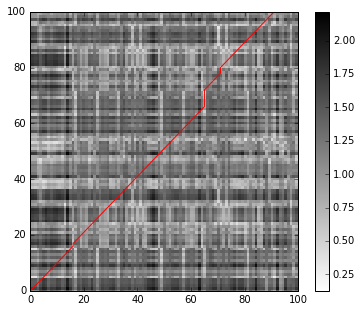

In [534]:
path, best_cost, path_costs = dtw(local_costs)

limit = 100
plt.figure(figsize=(6,5))
my_imshow(local_costs)
colorbar()
plot(path[:, 1], path[:, 0], '-r')
if limit:
    ylim([0, limit])
    xlim([0, limit])


1395.98028086
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 16 17 18]]
[[1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494
  1495 1496 1497 1498 1499 1500]
 [ 923  924  925  926  927  928  929  930  931  932  933  934  934  934
   935  936  937  938  939  940]]
0.930033498243
0.898668516401


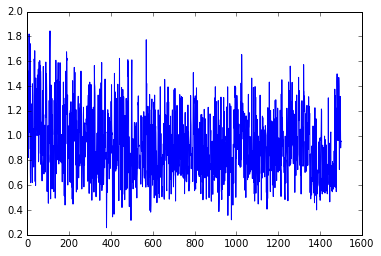

In [535]:
plot(path_costs)

print(best_cost)
print(path[:20].transpose())
print(path[-20:].transpose())
print(np.mean(path_costs))
print(np.median(path_costs))

In [315]:
def local_norm_dtw_cost(ftrs_A, ftrs_B):
    local_costs = sklearn.metrics.pairwise.pairwise_distances(ftrs_A, ftrs_B)
    local_mean_cost = scipy.ndimage.filters.gaussian_filter(local_costs, sigma=4.0)
    norm_costs = local_costs / local_mean_cost
    path, total_costs, path_cost = dtw(norm_costs, penalty=0.2)
    return np.median(path_cost), path, norm_costs

In [304]:
# Compute DTW costs for every pair of tracks.
dtw_costs = np.zeros((len(ids_A), len(ids_B)))
print(time.ctime())
for n_A, id_A in enumerate(ids_A):
    _, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_A + '.pkl'))
    #print(id_A)
    for n_B, id_B in enumerate(ids_B):
        _, ftrs_B, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_B + '.pkl'))
        dtw_costs[n_A, n_B], _, _ = local_norm_dtw_cost(ftrs_A, ftrs_B)
print(time.ctime())


Sun Apr 10 19:42:12 2016
Sun Apr 10 19:46:56 2016


0.0625


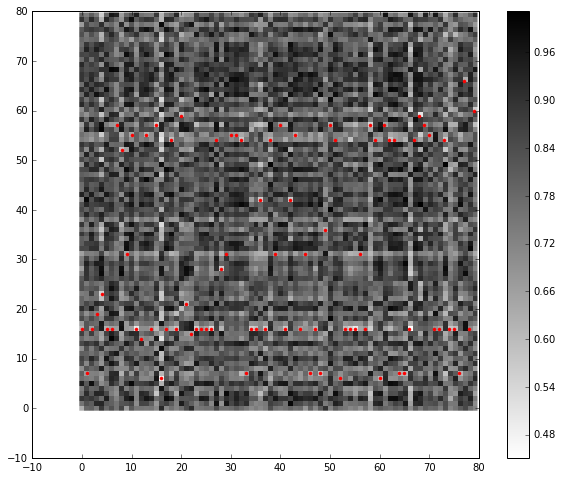

In [311]:
plt.figure(figsize=(10,8))
my_imshow(dtw_costs)
colorbar()
plot(np.argmin(dtw_costs, axis=0), '.r')
print(np.mean(np.argmin(dtw_costs, axis=1) == np.arange(80)))

In [513]:
ix1 = 1
ix2a = 1
ix2b = 63
id_A = ids_A[ix1]
id_Ba = ids_B[ix2a]
id_Bb = ids_B[ix2b]
print(id_A, id_Ba, id_Bb)
beats_A, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_A + '.pkl'))
beats_Ba, ftrs_Ba, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_Ba + '.pkl'))
beats_Bb, ftrs_Bb, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_Bb + '.pkl'))

Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra Abracadabra/sugar_ray+14_59+11-Abracadabra Take_Me_To_The_River/talking_heads+Stop_Making_Sense+09-Take_Me_To_The_River


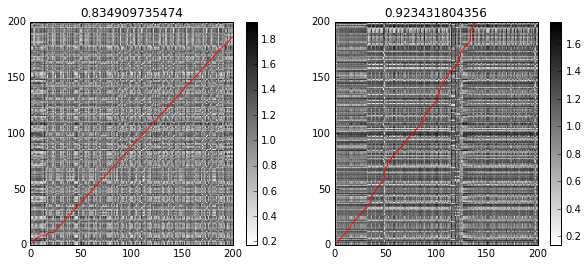

In [514]:
bestcost_ABa, path_ABa, costs_ABa = local_norm_dtw_cost(ftrs_A, ftrs_Ba)
bestcost_ABb, path_ABb, costs_ABb = local_norm_dtw_cost(ftrs_A, ftrs_Bb)

limit = 200
plt.figure(figsize=(10,4))

subplot(121)
my_imshow(costs_ABa[:limit, :limit])
colorbar()
plot(path_ABa[:limit, 1], path_ABa[:limit, 0], '-r')
xlim([0, limit])
ylim([0, limit])
title(str(bestcost_ABa))

subplot(122)
my_imshow(costs_ABb[:limit, :limit])
colorbar()
plot(path_ABb[:limit, 1], path_ABb[:limit, 0], '-r')
xlim([0, limit])
ylim([0, limit])
title(str(bestcost_ABb))

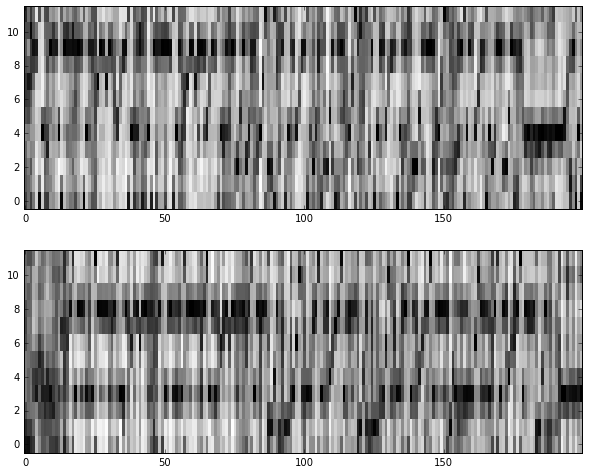

In [515]:
plt.figure(figsize=(10,8))
limit = 200
subplot(211)
my_imshow(ftrs_A[:limit].transpose())
subplot(212)
my_imshow(ftrs_Ba[:limit].transpose())

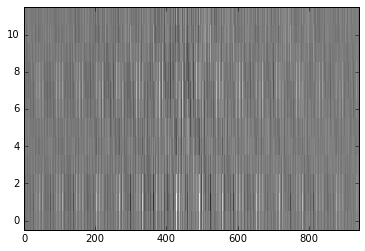

In [518]:
def correlation_similarity(ftrs_A, ftrs_B):
    xcorr = scipy.signal.convolve2d(scipy.signal.lfilter([1, -1], [1], ftrs_A, axis=0), 
                                    np.hstack([ftrs_B, ftrs_B])[::-1, ::-1], mode='same')
    return xcorr

xc = correlation_similarity(ftrs_A, ftrs_Ba).transpose()
 
_ = plot(xc.transpose())
my_imshow(xc)

In [348]:
scores = np.zeros((len(ids_A), len(ids_B)))
print(time.ctime())
for n_A, id_A in enumerate(ids_A):
    _, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_A + '.pkl'))
    print(time.ctime(), n_A, "of", len(ids_A), id_A)
    for n_B, id_B in enumerate(ids_B):
        _, ftrs_B, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_B + '.pkl'))
        scores[n_A, n_B] = np.max(correlation_similarity(ftrs_A, ftrs_B))
print(time.ctime())



Sun Apr 10 21:35:19 2016
A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale
Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra
Addicted_To_Love/robert_palmer+Riptide+03-Addicted_To_Love
All_Along_The_Watchtower/bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower
All_Tomorrow_s_Parties/japan+Quiet_Life+06-All_Tomorrow_s_Parties
America/paul_simon+Concert_in_the_Park_Disc_2+09-America
Before_You_Accuse_Me/creedence_clearwater_revival+Cosmo_s_Factory+02-Before_You_Accuse_Me
Between_The_Bars/elliott_smith+Either_Or+04-Between_The_Bars
Blue_Collar_Man/reo_speedwagon+Arch_Allies_Disc_1+01-Blue_Collar_Man
Caroline_No/beach_boys+Pet_Sounds+13-Caroline_No
Cecilia/paul_simon+Concert_in_the_Park_Disc_2+11-Cecilia
Claudette/everly_brothers+The_Fabulous_Style_of+01-Claudette
Cocaine/eric_clapton+Crossroads_2_Disc_3+07-Cocaine
Come_Together/aerosmith+Live_Bootleg+06-Come_Together
Day_Tripper/beatles+1+12-Day_Tripper
Don_t_Let_It_Bring_You_Down/annie_l

0.2875


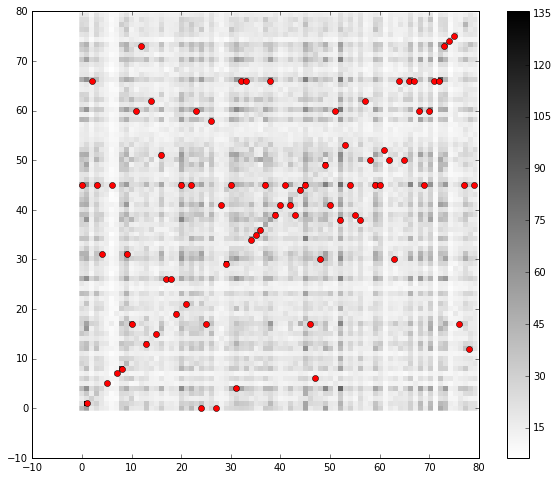

In [351]:
plt.figure(figsize=(10,8))
my_imshow(costs)
colorbar()
plot(np.argmax(costs, axis=0), 'or')
print(np.mean(np.argmax(costs, axis=1) == np.arange(80)))

In [456]:
def best_chroma_similarity(chroma_A, chroma_B):
    """Return a chroma_A.shape[0], chroma_B.shape[1] array of best-matching chroma rotations."""
    num_frames_A, num_chroma = chroma_A.shape
    num_frames_B, num_chroma_B = chroma_B.shape
    mod_chroma_B = np.copy(chroma_B)
    assert num_chroma == num_chroma_B
    similarities = np.zeros((num_chroma, num_frames_A, num_frames_B))
    rotate_chroma_indices = np.hstack([np.arange(1, num_chroma), 0])
    for i in xrange(num_chroma):
        similarities[i] = sklearn.metrics.pairwise.pairwise_distances(chroma_A, mod_chroma_B, metric='cosine')
        # Rotate chroma of B.
        mod_chroma_B = mod_chroma_B[:, rotate_chroma_indices]
    return np.argmin(similarities, axis=0)

def best_chroma_dtw_cost(ftrs_A, ftrs_B):
    chroma_rots = best_rotation_similarity(ftrs_A, ftrs_B)
    # Find the most popular rotation.
    counts = np.bincount(chroma_rots.flatten())
    best_trans = np.argmax(counts)
    #print("Best transposition=", best_trans)
    best_trans_dist = (chroma_rots != best_trans).astype(float)
    # Calculate DTW cost through binarized matrix.
    path, best_cost, path_cost = dtw(best_trans_dist, penalty=0.2)
    return np.mean(path_cost), path, best_trans_dist


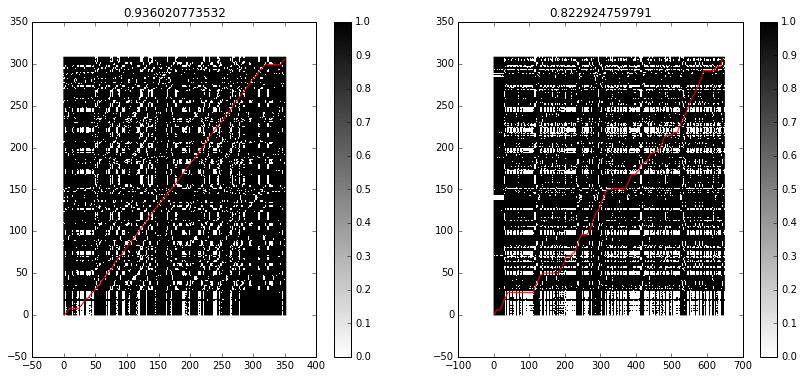

In [479]:
best_cost_ABa, path_ABa, best_trans_dist_ABa = best_chroma_dtw_cost(ftrs_A, ftrs_Ba)
best_cost_ABb, path_ABb, best_trans_dist_ABb = best_chroma_dtw_cost(ftrs_A, ftrs_Bb)

limit = 0
plt.figure(figsize=(14,6))

subplot(121)
my_imshow(best_trans_dist_ABa)
colorbar()
plot(path_ABa[1:-1, 1], path_ABa[1:-1, 0], '-r')
if limit:
    xlim([0, limit])
    ylim([0, limit])
title(str(bestcost_ABa))

subplot(122)
my_imshow(best_trans_dist_ABb)
colorbar()
plot(path_ABb[1:-1, 1], path_ABb[1:-1, 0], '-r')
if limit:
    xlim([0, limit])
    ylim([0, limit])
title(str(bestcost_ABb))


In [409]:
trans_costs = np.zeros((len(ids_A), len(ids_B)))
print(time.ctime())
for n_A, id_A in enumerate(ids_A):
    _, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_A + '.pkl'))
    print(time.ctime(), n_A, "of", len(ids_A), id_A)
    for n_B, id_B in enumerate(ids_B):
        _, ftrs_B, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, id_B + '.pkl'))
        trans_costs[n_A, n_B], _, _ = best_chroma_dtw_cost(ftrs_A, ftrs_B)
print(time.ctime())

Sun Apr 10 23:00:02 2016
Sun Apr 10 23:00:02 2016 0 of 80 A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale
Sun Apr 10 23:00:24 2016 1 of 80 Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra
Sun Apr 10 23:00:36 2016 2 of 80 Addicted_To_Love/robert_palmer+Riptide+03-Addicted_To_Love
Sun Apr 10 23:00:47 2016 3 of 80 All_Along_The_Watchtower/bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower
Sun Apr 10 23:01:01 2016 4 of 80 All_Tomorrow_s_Parties/japan+Quiet_Life+06-All_Tomorrow_s_Parties
Sun Apr 10 23:01:20 2016 5 of 80 America/paul_simon+Concert_in_the_Park_Disc_2+09-America
Sun Apr 10 23:01:30 2016 6 of 80 Before_You_Accuse_Me/creedence_clearwater_revival+Cosmo_s_Factory+02-Before_You_Accuse_Me
Sun Apr 10 23:01:35 2016 7 of 80 Between_The_Bars/elliott_smith+Either_Or+04-Between_The_Bars
Sun Apr 10 23:01:39 2016 8 of 80 Blue_Collar_Man/reo_speedwagon+Arch_Allies_Disc_1+01-Blue_Collar_Man
Sun Apr 10 23:01:56 2016 9 of 80 Caroline_No/bea

0.35


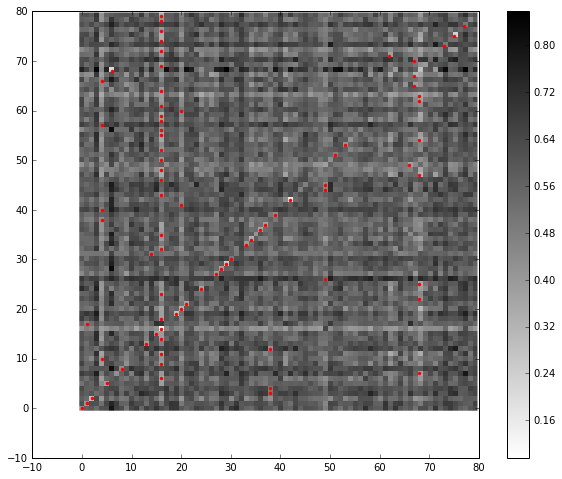

In [472]:
plt.figure(figsize=(10,8))
my_imshow(trans_costs)
colorbar()
plot(np.argmin(trans_costs, axis=1), np.arange(trans_costs.shape[0]), '.r')
print(np.mean(np.argmin(trans_costs, axis=1) == np.arange(80)))

In [452]:
ix = 16
_, ftrs_A, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, ids_A[ix] + '.pkl'))
_, ftrs_B, _ = read_beat_chroma_labels(os.path.join(PKL_DIR, ids_B[ix] + '.pkl'))
print(ftrs_A.shape)
print(ftrs_B.shape)
tc = np.zeros((2, 2))
tc[0, 0] = np.max(correlation_similarity(ftrs_A, ftrs_B))
tc[0, 1] = np.max(correlation_similarity(ftrs_A, ftrs_B[::2]))
tc[1, 0] = np.max(correlation_similarity(ftrs_A[::2], ftrs_B))
tc[1, 1] = np.max(correlation_similarity(ftrs_A[1::2], ftrs_B))
print(tc)


(1312, 12)
(1252, 12)
[[ 42.55049618  15.10080514]
 [ 33.50621529  33.61134866]]
